In [6]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.optim import Adam

# 二维数据[SEQ_LEN, VOCAB_SIZE]

## 生成sin数据

In [428]:
x = np.arange(-10, 10, 0.2, dtype=np.float32) * np.pi / 4
y = np.sin(x) + np.random.normal(0, 0.03, len(x))
y = y.astype(np.float32)

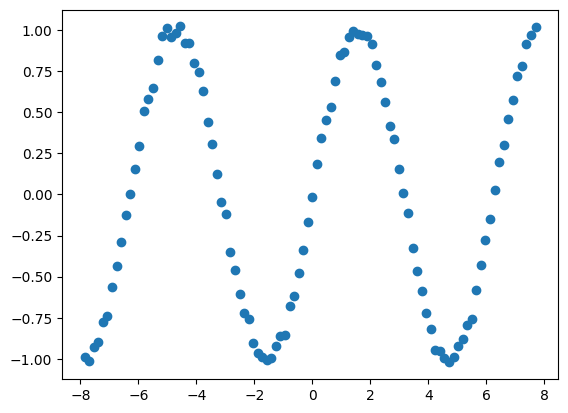

In [429]:
plt.scatter(x, y)

In [430]:
x_tensor = torch.from_numpy(x).reshape(-1, 1)
y_tensor = torch.from_numpy(y).reshape(-1, 1)

## BaseModel&train

In [431]:
class RNNModel2Dim(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer: nn.Module, vocab_size: int) -> None:
        super().__init__()
        self.rnn         = rnn_layer
        self.hidden_size = rnn_layer.hidden_size
        self.num_layers  = rnn_layer.num_layers
        self.vocab_size  = vocab_size

        # 如果RNN是双向的（之后将介绍），num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.hidden_size, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.hidden_size * 2, self.vocab_size)

    def forward(self, x, state=None):
        y, state = self.rnn(x, state)
        # y为每个时间步得到的state,所以是对每个state的预测值
        output = self.linear(y)
        return output, state

    def begin_state(self):
        # 二维没有batch
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros(self.num_directions * self.num_layers, self.hidden_size)
        else:
            return (torch.zeros(self.num_directions * self.num_layers, self.hidden_size),
                    torch.zeros(self.num_directions * self.num_layers, self.hidden_size))

In [432]:
def train_2dim(epochs, rnn, optimizer, loss_fn, x, y):
    losses = []
    state = rnn.begin_state()
    rnn.train()
    for i in range(epochs):
        optimizer.zero_grad()

        #----------------------------------------------------------#
        #   Trying to backward through the graph a second time...
        #   detach
        #----------------------------------------------------------#
        if not isinstance(state, tuple):
            state = state.detach()
        else:
            hx, cx = state
            hx, cx = hx.detach(), cx.detach()
            state = (hx, cx)

        y_pred, state = rnn(x, state)
        loss = loss_fn(y_pred, y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
    return losses

## RNN

In [433]:
x_tensor.shape
# [len, VOCAB_SIZE]

torch.Size([100, 1])

In [434]:
HIDDEN_SIZE = 16
NUM_LAYERS = 2
rnn1 = nn.RNN(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, bias=True, batch_first=False, bidirectional=False)

In [435]:
h0 = torch.randn(NUM_LAYERS, HIDDEN_SIZE)
# output = [h1, h2, ..., hx] 为每个时间步得到的hidden_state
# hx                         为最后一个时间步的hidden_state
output, hx = rnn1(x_tensor, h0)
print(output.size(), hx.size())

torch.Size([100, 16]) torch.Size([2, 16])


In [436]:
# output包含所有时间步的最后一层的hidden_state
print(output[-1].shape, hx.shape)
print(output[-1] == hx)

torch.Size([16]) torch.Size([2, 16])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True]])


In [437]:
# output包含所有时间步的最后一层的hidden_state
print(output[-1].shape, hx[-1].shape)
print(output[-1] == hx[-1])

torch.Size([16]) torch.Size([16])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


In [438]:
rnn2 = RNNModel2Dim(rnn1, vocab_size=1)
state = rnn2.begin_state()
state.shape

torch.Size([2, 16])

In [439]:
optimizer = Adam(rnn2.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [440]:
y_pred, state = rnn2(x_tensor, state)
print(y_pred.shape, state.shape)

torch.Size([100, 1]) torch.Size([2, 16])


In [442]:
losses =  train_2dim(200, rnn2, optimizer, loss_fn, x_tensor, y_tensor)

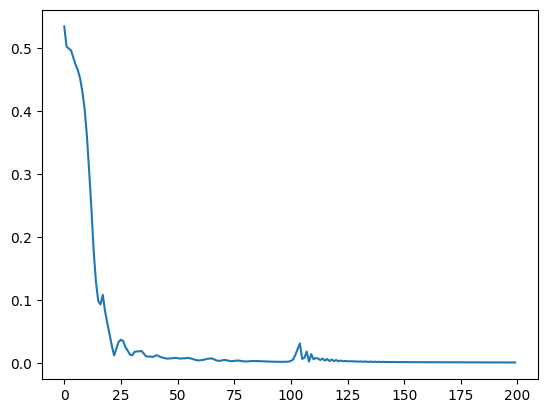

In [443]:
plt.plot(np.arange(len(losses)), losses)

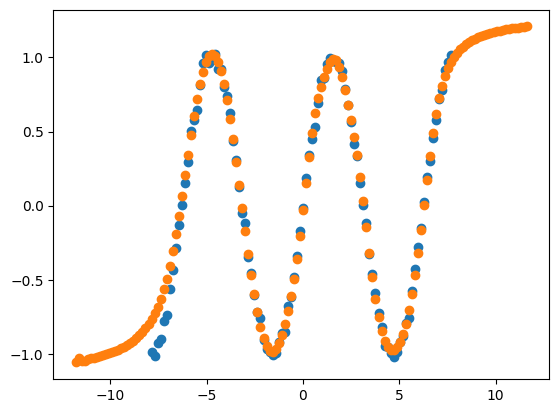

In [444]:
rnn2.eval()
plt.scatter(x, y)
temp_x = np.arange(-15, 15, 0.2, dtype=np.float32) * np.pi / 4
temp_y = rnn2(torch.from_numpy(temp_x).reshape(-1, 1).type(torch.float32))[0].flatten().detach().numpy()
plt.scatter(temp_x, temp_y)

## GRU

In [445]:
x_tensor.shape
# [len, VOCAB_SIZE]

torch.Size([100, 1])

In [446]:
HIDDEN_SIZE = 16
NUM_LAYERS = 2
gru1 = nn.GRU(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, bias=True, batch_first=False, bidirectional=False)

In [447]:
h0 = torch.randn(NUM_LAYERS, HIDDEN_SIZE)
# output = [h1, h2, ..., hx] 为每个时间步得到的hidden_state
# hx                         为最后一个时间步的hidden_state
output, hx = gru1(x_tensor, h0)
print(output.size(), hx.size())

torch.Size([100, 16]) torch.Size([2, 16])


In [448]:
# output包含所有时间步的最后一层的hidden_state
print(output[-1].shape, hx.shape)
print(output[-1] == hx)

torch.Size([16]) torch.Size([2, 16])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True]])


In [449]:
# output包含所有时间步的最后一层的hidden_state
print(output[-1].shape, hx[-1].shape)
print(output[-1] == hx[-1])

torch.Size([16]) torch.Size([16])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


In [450]:
gru2 = RNNModel2Dim(gru1, vocab_size=1)
state = gru2.begin_state()
state.shape

torch.Size([2, 16])

In [451]:
optimizer = Adam(gru2.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [452]:
y_pred, state = gru2(x_tensor, state)
print(y_pred.shape, state.shape)

torch.Size([100, 1]) torch.Size([2, 16])


In [454]:
losses =  train_2dim(200, gru2, optimizer, loss_fn, x_tensor, y_tensor)

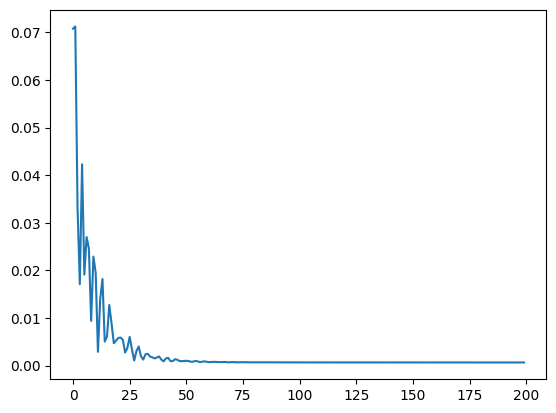

In [455]:
plt.plot(np.arange(len(losses)), losses)

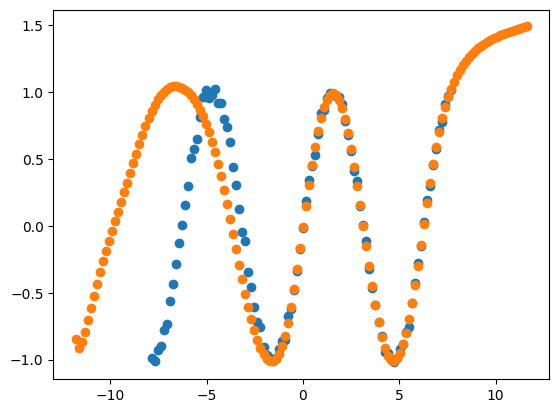

In [456]:
gru2.eval()
plt.scatter(x, y)
temp_x = np.arange(-15, 15, 0.2, dtype=np.float32) * np.pi / 4
temp_y = gru2(torch.from_numpy(temp_x).reshape(-1, 1).type(torch.float32))[0].flatten().detach().numpy()
plt.scatter(temp_x, temp_y)

## LSTM

In [457]:
x_tensor.shape
# [len, VOCAB_SIZE]

torch.Size([100, 1])

In [458]:
HIDDEN_SIZE = 16
NUM_LAYERS = 2
lstm1 = nn.LSTM(input_size=1, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, bias=True, batch_first=False, bidirectional=False)

In [459]:
#                2, num_layers, hidden_size
h0 = torch.randn(NUM_LAYERS, HIDDEN_SIZE)
c0 = torch.randn(NUM_LAYERS, HIDDEN_SIZE)
# output = [h1, h2, ..., hx] 为每个时间步得到的hidden_state
# hx                         为最后一个时间步的hidden_state
# cx                         为最后一个时间步的memory_state
output, (hx, cx) = lstm1(x_tensor, (h0, c0))
print(output.size(), hx.size(), cx.size())

torch.Size([100, 16]) torch.Size([2, 16]) torch.Size([2, 16])


In [460]:
# output包含所有时间步的最后一层的hidden_state
print(output[-1].shape, hx.shape)
print(output[-1] == hx)


torch.Size([16]) torch.Size([2, 16])
tensor([[False, False, False, False, False, False, False, False, False, False,
         False, False, False, False, False, False],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True]])


In [461]:
# output包含所有时间步的最后一层的hidden_state
print(output[-1].shape, hx[-1].shape)
print(output[-1] == hx[-1])

torch.Size([16]) torch.Size([16])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True])


In [462]:
lstm2 = RNNModel2Dim(lstm1, vocab_size=1)
h0, c0 = lstm2.begin_state()
h0.size(), c0.size()

(torch.Size([2, 16]), torch.Size([2, 16]))

In [463]:
optimizer = Adam(lstm2.parameters(), lr=0.01)
loss_fn = nn.MSELoss()

In [464]:
y_pred, (hx, cx) = lstm2(x_tensor, (h0, c0))
print(y_pred.shape, hx.shape, cx.shape)

torch.Size([100, 1]) torch.Size([2, 16]) torch.Size([2, 16])


In [465]:
losses =  train_2dim(200, lstm2, optimizer, loss_fn, x_tensor, y_tensor)

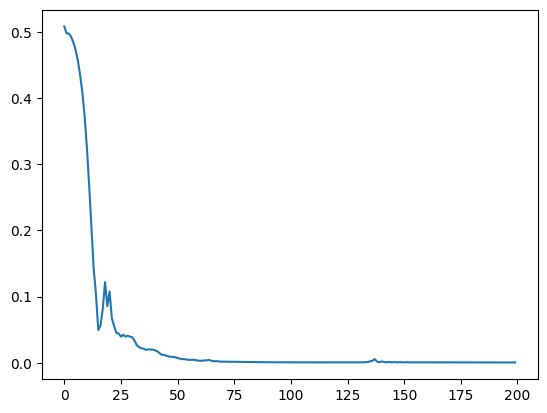

In [466]:
plt.plot(np.arange(len(losses)), losses)

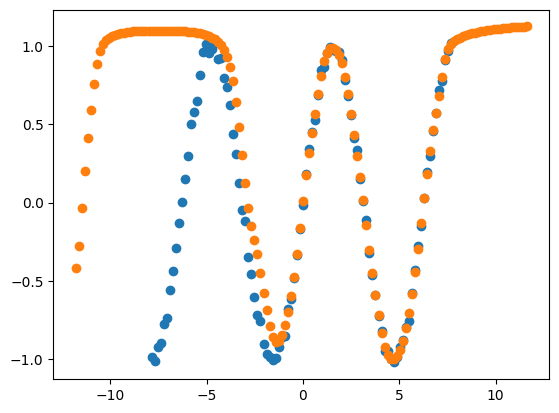

In [467]:
lstm2.eval()
plt.scatter(x, y)
temp_x = np.arange(-15, 15, 0.2, dtype=np.float32) * np.pi / 4
temp_y = lstm2(torch.from_numpy(temp_x).reshape(-1, 1).type(torch.float32))[0].flatten().detach().numpy()
plt.scatter(temp_x, temp_y)

# 三维数据[SEQ_LEN, BATCH_SIZE, VOCAB_SIZE]

## 生成三维数据

In [7]:
BATCH_SIZE    = 10  # batch
SEQ_LEN       = 20  # 句子长度
VOCAB_SIZE    = 100 # 字典长度
EMBEDDING_DIM = 32  # embedding的长度
HIDDEN_SIZE   = 256 # 隐藏层宽度
NUM_LAYERS    = 3   # 隐藏层深度

In [8]:
x = torch.ones(SEQ_LEN, BATCH_SIZE, EMBEDDING_DIM)
x.shape

torch.Size([20, 10, 32])

## BaseModel&train

http://zh.d2l.ai/chapter_recurrent-neural-networks/rnn-scratch.html

http://zh.d2l.ai/chapter_recurrent-neural-networks/rnn-concise.html

In [116]:
class RNNModel(nn.Module):
    """循环神经网络模型"""
    def __init__(self, rnn_layer: nn.RNNBase, embedding: nn.Module, vocab_size: int) -> None:
        super().__init__()
        self.embedding   = embedding
        self.rnn         = rnn_layer
        self.hidden_size = rnn_layer.hidden_size
        self.num_layers  = rnn_layer.num_layers
        self.vocab_size  = vocab_size

        # 如果RNN是双向的，num_directions应该是2，否则应该是1
        if not self.rnn.bidirectional:
            self.num_directions = 1
            self.linear = nn.Linear(self.hidden_size, self.vocab_size)
        else:
            self.num_directions = 2
            self.linear = nn.Linear(self.hidden_size * 2, self.vocab_size)

    def forward(self, x: torch.Tensor, state: torch.Tensor=None) -> tuple[torch.Tensor]:
        """
        Args:
            x (torch.Tensor):               [SEQ_LEN, BATCH_SIZE]
            state (torch.Tensor, optional): [NUM_DRIECT * NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]. Defaults to None.

        Returns:
            tuple[torch.Tensor]: predict, new state
        """

        # [SEQ_LEN, BATCH_SIZE] => [SEQ_LEN, BATCH_SIZE, EMBEDDING_DIM]
        x_embed = self.embedding(x)

        # y为每个时间步得到的state,所以是对每个state的预测值
        # y:      [SEQ_LEN, BATCH_SIZE, EMBEDDING_DIM] => [SEQ_LEN, BATCH_SIZE, HIDDEN_SIZE]
        # state:  形状不变
        y, state = self.rnn(x_embed, state)

        # 在最后维度处理,对于batch在哪个维度没影响
        # output: [SEQ_LEN, BATCH_SIZE, HIDDEN_SIZE] => [SEQ_LEN, BATCH_SIZE, VOCAB_SIZE]
        output = self.linear(y)
        return output, state

    def begin_state(self, batch_size: int):
        # [NUM_DRIECT * NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]
        if not isinstance(self.rnn, nn.LSTM):
            return torch.zeros(self.num_directions * self.num_layers, batch_size, self.hidden_size)
        else:
            return (torch.zeros(self.num_directions * self.num_layers, batch_size, self.hidden_size),
                    torch.zeros(self.num_directions * self.num_layers, batch_size, self.hidden_size))

## Dataset

In [117]:
from torch.utils.data import Dataset, DataLoader

In [209]:
class Data(Dataset):
    def __init__(self) -> None:
        # [BATCH_SUM, SEQ_LEN]
        # 一只棕色的狐狸跳过一只懒惰的狗。  使用int是类比下标
        self.x = torch.randint(0, VOCAB_SIZE, (1000, SEQ_LEN))
        # 只棕色的狐狸跳过一只懒惰的狗。    y是下一个字的真实值
        self.y = torch.randint(0, VOCAB_SIZE, (1000, SEQ_LEN))

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return len(x)

In [210]:
dataloader = DataLoader(Data(), batch_size=BATCH_SIZE, shuffle=False)

In [211]:
next(iter(dataloader))[0].shape
# [BATCH_SIZE, SEQ_LEN]

torch.Size([10, 20])

## train func

In [215]:
def train(epochs, rnn: RNNModel, optimizer, loss_fn):
    dataloader = DataLoader(Data(), batch_size=BATCH_SIZE, shuffle=False)

    rnn.train()
    losses = []
    for i in range(epochs):
        loss_e = []
        for x, y in dataloader:
            # [BATCH_SIZE, SEQ_LEN] => [SEQ_LEN, BATCH_SIZE]
            x, y = x.T, y.T

            # 初始状态,每个iter都要使用新的
            state = rnn.begin_state(BATCH_SIZE)

            # x&y: [SEQ_LEN, BATCH_SIZE]
            optimizer.zero_grad()

            #----------------------------------------------------------#
            #   Trying to backward through the graph a second time...
            #   detach
            #----------------------------------------------------------#
            if not isinstance(state, tuple):
                state = state.detach()
            else:
                # lstm 有2个隐藏层
                hx, cx = state
                hx, cx = hx.detach(), cx.detach()
                state = (hx, cx)

            y_pred, state = rnn(x, state)
            # y_pred: [SEQ_LEN, BATCH_SIZE, VOCAB_SIZE] => [SEQ_LEN * BATCH_SIZE, VOCAB_SIZE]
            # y:      [SEQ_LEN, BATCH_SIZE]             => [SEQ_LEN * BATCH_SIZE]
            loss = loss_fn(y_pred.reshape(-1, y_pred.shape[-1]), y.flatten())
            loss.backward()
            loss_e.append(loss.item())
            optimizer.step()
        losses.append(np.mean(loss_e))

    return losses

## RNN

### nn.RNN

In [216]:
rnn3 = nn.RNN(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, bias=True, batch_first=False, bidirectional=False)

In [217]:
h0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
# output = [h1, h2, ..., hx] 为每个时间步得到的hidden_state
# hx                         为最后一个时间步的hidden_state
output, hx = rnn3(x, h0)
print(output.size(), hx.size())
# [SEQ_LEN,    BATCH_SIZE, HIDDEN_SIZE]
# [NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]

torch.Size([20, 10, 256]) torch.Size([3, 10, 256])


In [218]:
# output包含所有时间步的最后一层的hidden_state
print(torch.all(output[-1] == hx))
print(torch.all(output[-1] == hx[-1]))

tensor(False)
tensor(True)


### RNNModel

In [219]:
embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
rnn4 = RNNModel(rnn3, embedding=embedding, vocab_size=VOCAB_SIZE)

In [220]:
h0 = rnn4.begin_state(batch_size=BATCH_SIZE)
temp_x = torch.randint(0, VOCAB_SIZE, (SEQ_LEN, BATCH_SIZE))
output, hx = rnn4(temp_x, h0)
print(temp_x.shape)         # [SEQ_LEN,    BATCH_SIZE]
print(output.shape)         # [SEQ_LEN,    BATCH_SIZE, VOCAB_SIZE]
print(h0.shape, hx.shape)   # [NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]

torch.Size([20, 10])
torch.Size([20, 10, 100])
torch.Size([3, 10, 256]) torch.Size([3, 10, 256])


### train

In [221]:
optimizer = Adam(rnn4.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(10, rnn4, optimizer, loss_fn)

[4.608611583709717,
 4.4490907192230225,
 4.294214963912964,
 4.123337984085083,
 3.9207801818847656,
 3.7030551433563232,
 3.4724737405776978,
 3.2357932329177856,
 2.9996944665908813,
 2.7594683170318604]

## GRU

### nn.GRU

In [222]:
gru3 = nn.GRU(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, bias=True, batch_first=False, bidirectional=False)

In [223]:
h0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
# output = [h1, h2, ..., hx] 为每个时间步得到的hidden_state
# hx                         为最后一个时间步的hidden_state
output, hx = gru3(x, h0)
print(output.size(), hx.size())
# [SEQ_LEN,    BATCH_SIZE, HIDDEN_SIZE]
# [NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]

torch.Size([20, 10, 256]) torch.Size([3, 10, 256])


In [224]:
# output包含所有时间步的最后一层的hidden_state
print(torch.all(output[-1] == hx))
print(torch.all(output[-1] == hx[-1]))

tensor(False)
tensor(True)


### RNNModel

In [225]:
embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
gru4 = RNNModel(gru3, embedding=embedding, vocab_size=VOCAB_SIZE)

In [226]:
h0 = gru4.begin_state(batch_size=BATCH_SIZE)
temp_x = torch.randint(0, VOCAB_SIZE, (SEQ_LEN, BATCH_SIZE))
output, hx = gru4(temp_x, h0)
print(temp_x.shape)         # [SEQ_LEN,    BATCH_SIZE]
print(output.shape)         # [SEQ_LEN,    BATCH_SIZE, VOCAB_SIZE]
print(h0.shape, hx.shape)   # [NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]

torch.Size([20, 10])
torch.Size([20, 10, 100])
torch.Size([3, 10, 256]) torch.Size([3, 10, 256])


### train

In [227]:
optimizer = Adam(gru4.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(10, gru4, optimizer, loss_fn)

[4.6082377433776855,
 4.57039475440979,
 4.530970573425293,
 4.477245092391968,
 4.422670125961304,
 4.361980676651001,
 4.274073362350464,
 4.182175636291504,
 4.082669019699097,
 3.964216709136963]

## LSTM

### nn.LSTM

In [228]:
lstm3 = nn.LSTM(input_size=EMBEDDING_DIM, hidden_size=HIDDEN_SIZE, num_layers=NUM_LAYERS, bias=True, batch_first=False, bidirectional=False)

In [229]:
h0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
c0 = torch.randn(NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE)
# output = [h1, h2, ..., hx] 为每个时间步得到的hidden_state
# hx                         为最后一个时间步的hidden_state
# cx                         为最后一个时间步的memory_state
output, (hx, cx) = lstm3(x, (h0, c0))
print(output.size(), hx.size(), cx.size())
# [SEQ_LEN,    BATCH_SIZE, HIDDEN_SIZE]
# [NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]
# [NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]

torch.Size([20, 10, 256]) torch.Size([3, 10, 256]) torch.Size([3, 10, 256])


In [230]:
# output包含所有时间步的最后一层的hidden_state
print(torch.all(output[-1] == hx))
print(torch.all(output[-1] == hx[-1]))

tensor(False)
tensor(True)


### RNNModel

In [231]:
embedding = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)
lstm4 = RNNModel(lstm3, embedding=embedding, vocab_size=VOCAB_SIZE)

In [232]:
h0, c0 = lstm4.begin_state(batch_size=BATCH_SIZE)
temp_x = torch.randint(0, VOCAB_SIZE, (SEQ_LEN, BATCH_SIZE))
output, (hx, cx) = lstm4(temp_x, (h0, c0))
print(temp_x.shape)                 # [SEQ_LEN,    BATCH_SIZE]
print(output.shape)                 # [SEQ_LEN,    BATCH_SIZE, VOCAB_SIZE]
print(h0.shape, hx.shape, cx.shape) # [NUM_LAYERS, BATCH_SIZE, HIDDEN_SIZE]

torch.Size([20, 10])
torch.Size([20, 10, 100])
torch.Size([3, 10, 256]) torch.Size([3, 10, 256]) torch.Size([3, 10, 256])


In [233]:
optimizer = Adam(lstm4.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(10, lstm4, optimizer, loss_fn)

[4.604182481765747,
 4.5907862186431885,
 4.571564197540283,
 4.527948617935181,
 4.506953239440918,
 4.479104518890381,
 4.4638214111328125,
 4.455384969711304,
 4.436837196350098,
 4.408071994781494]